### Contributors:
- Tao Li (tl2863), tl2863@columbia.edu, https://github.com/Megatao
- Naili Ding (nd2588), nd2588@columbia.edu, https://github.com/nding17
- Chaoyue Zheng (cz2529), cz2529@columbia.edu, https://github.com/chaoyuezheng
- Jinglin Chen (jc5059), jc5059@columbia.edu, https://github.com/Jinglinchen97

 # Movie Reommendation 


## Outline
- Sampling Method
- Recommendation Models
    - Baseline
    - Item/User Based
    - Model Based
- Hyper-parameters Tuning
    - KNN 
        - K (# of users/items in the peer set)
    - Matrix Factorization
        - Latent Factor
        - Regularization term
- Evaluation Metrics
    - Accuracy 
        - RMSE
        - MAE
    - Coverage
        - Catelog
- Recommendation/Prediction
    - Item based CF recommendation
    - Model based CF recommendation

# Import Packages 

In [7]:
import pandas as pd
import numpy as np
import datetime
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
from surprise.prediction_algorithms.algo_base import AlgoBase
from surprise.prediction_algorithms.baseline_only import BaselineOnly 
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection.validation import cross_validate
from surprise.model_selection.search import GridSearchCV
from surprise.model_selection import train_test_split
import recmetrics

# Item-based CF
from surprise import Dataset, Reader
from surprise.model_selection.validation import cross_validate
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from collections import defaultdict

from IPython.display import Image
import os

if not os.path.exists("images"):
    os.mkdir("images")

# I. Sample Movie Data



In [2]:
spark = SparkSession.builder.getOrCreate()
ratings = pd.read_csv("./data/ratings.csv")
ratings['timestamp'] = ratings['timestamp'].apply(datetime.datetime.fromtimestamp)
sample = ratings[ratings['timestamp'].apply(lambda x: x.date()) >= datetime.date(2013,3,31)]

# II. Statistical Description for Data

- There're 1281535 ratings, that comes from 13092 users for 22648 movies. 

###  2.1 Rating Distribution

We can see that most ratings in the data are over 3, accounts for over 83% and very few ratings are between 0.5 and 3.

In [3]:
user_num = sample.userId.unique().shape[0]
movie_num = sample.movieId.unique().shape[0]
print(user_num, "unique users in sample, and", movie_num, "unique movies in sample")

13086 unique users in sample, and 22646 unique movies in sample


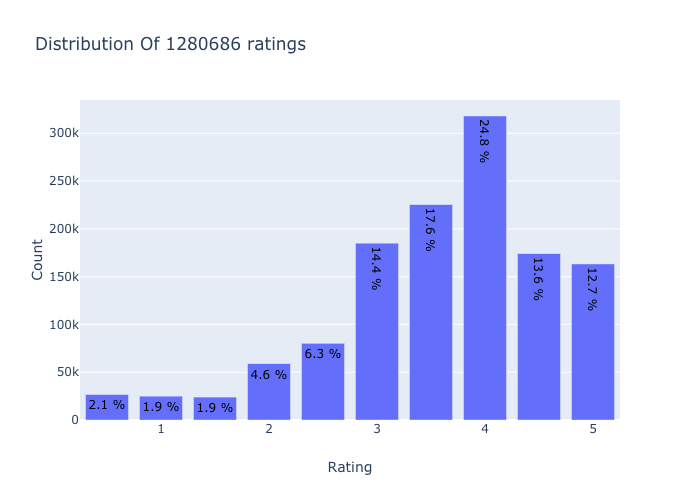

In [4]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = sample['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / sample.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} ratings'.format(sample.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.write_image('./images/ratings_dist.png')
Image('./images/ratings_dist.png')

### 2.2 Rating Distribution by Movie
Most of Movies receive less than 10 ratings, and very few movies have many ratings, although the most rated movies has 5452 ratings


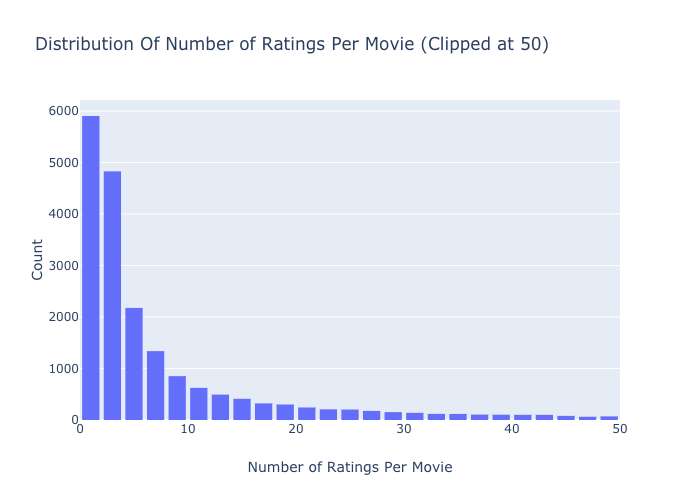

In [5]:
# Number of ratings per movie
data = sample.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'rating',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.write_image('./images/dist_by_movie.png')
Image('./images/dist_by_movie.png')

In [8]:
sample.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,movieId,rating
286,318,5452
2136,2571,5221
13047,79132,5156
10773,58559,5116
2471,2959,4760
4228,4993,4252
6034,7153,4197
267,296,4077
713,858,3921
477,527,3863


### 2.3 Rating Distribution by User
We can see that most users have more than 20 ratings.

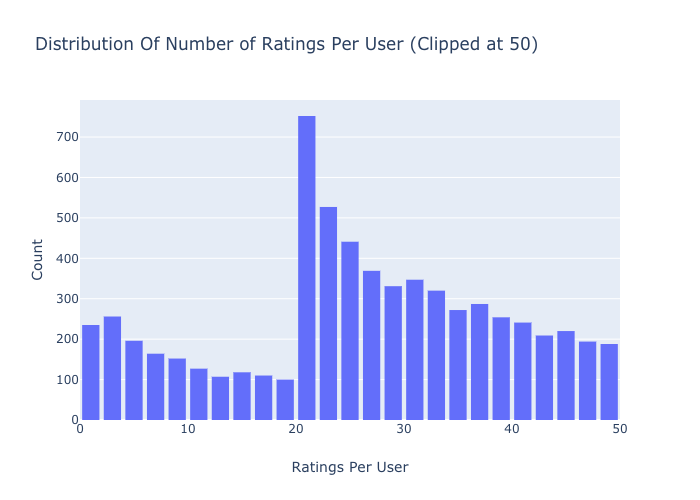

In [6]:
# Number of ratings per user
data = sample.groupby('userId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'rating',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
fig.write_image('./images/dist_by_user.png')
Image('./images/dist_by_user.png')

# III. Recommendation Models
- Baseline
- User/Item Based
- Model Based (Matrix Factorization)

## Baseline

----

In [10]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(sample[['userId','movieId','rating']],reader)

bsl_options = {'method':'sgd'}
baseline_algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(baseline_algo, data, measures=['rmse'], cv=3, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8436  0.8404  0.8417  0.8419  0.0013  
Fit time          5.21    5.39    6.00    5.53    0.34    
Test time         2.59    2.75    4.22    3.19    0.73    


{'test_rmse': array([0.84357685, 0.84038706, 0.84167366]),
 'fit_time': (5.206698894500732, 5.39443302154541, 6.00362491607666),
 'test_time': (2.593766927719116, 2.7471530437469482, 4.219043016433716)}

In [13]:
n_users = len(sample['userId'].unique())
users = np.linspace(1000, n_users, 5)
rmse_bsl = []
mae_bsl = []
runtime_bsl = []
for i in users:
    num_users = np.random.choice(sample['userId'].unique(),int(i),replace=False)
    sample_user = sample[sample['userId'].apply(lambda x: x in num_users)]
    reader = Reader(rating_scale=(0,5))
    data_user = Dataset.load_from_df(sample_user[['userId','movieId','rating']], reader)
    bsl_options = {'method':'sgd'}
    baseline_algo = BaselineOnly(bsl_options=bsl_options)
    result = cross_validate(baseline_algo, 
                            data_user, 
                            measures=['rmse','mae'], 
                            cv=5, 
                            verbose=False)
    avg_rmse = result['test_rmse'].mean()
    avg_mae = result['test_mae'].mean()
    avg_runtime = np.array([x for x in result['fit_time']]).mean()
    rmse_bsl.append(avg_rmse)
    mae_bsl.append(avg_mae)
    runtime_bsl.append(avg_runtime)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


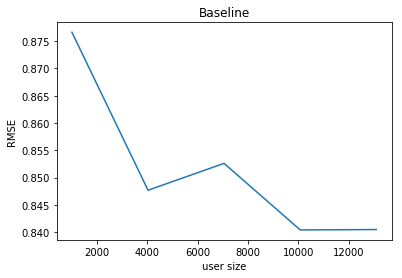

In [14]:
plt.plot(users, rmse_bsl)
plt.xlabel('user size')
plt.ylabel('RMSE')
plt.title('Baseline')
plt.show()

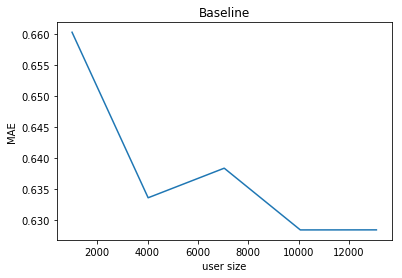

In [15]:
plt.plot(users, mae_bsl)
plt.xlabel('user size')
plt.ylabel('MAE')
plt.title('Baseline')
plt.show()

## User/Item based


------

### KNNBaseline Model (Without Tunning)

- We first compare the rmse accuracy metrics among the three KNN models, and find that KNNBaseline gives us best rmse. Hence we'll train and predict with KNNBaseline Model.
- As total movies number are far less than total users number, so we choose item-based model.

In [29]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(sample[['userId','movieId','rating']],reader)

benchmark = []
# Iterate over all algorithms
for algorithm in (KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()):
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.836979,59.692415,272.246816
KNNWithMeans,0.855600,216.479112,393.675515
KNNWithZScore,0.859556,59.711090,294.910282
KNNBasic,0.901272,134.470639,423.852626


In [39]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.2)
sim_options = {'name': 'pearson_baseline', 'user_based': False}
KNN_algo = KNNBaseline(k=40, sim_options=sim_options)
KNN_algo.fit(trainset)
KNN_test = KNN_algo.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### Hyper-parameter Tuning
- Using gridsearch, we find that K=40, similarity option = pearson baseline, method = als will give us best RMSE.

In [38]:
from surprise.model_selection.search import GridSearchCV
#tuning the parameters
param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [10, 40],
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }

#Evaluation model
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_params['rmse'])

{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 40, 'sim_options': {'name': 'pearson_baseline', 'min_support': 1, 'user_based': False}}


- select best K for different size of datasets

In [4]:
def tunning_k(n_users = 10):
    benchmark = []
    all_users = sample.userId.unique()
    nusers = np.random.choice(all_users, n_users, replace=False)
    nsample = sample.loc[sample.userId.isin(nusers)]
    data = Dataset.load_from_df(nsample[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5)))
    for k in [10,25,40]:
        trainset = data.build_full_trainset()
        sim_options = {'name': 'pearson_baseline', 'user_based': False}
        algo = KNNBaseline(k=k, sim_options=sim_options)
        results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(k).split(' ')[0].split('.')[-1]], index=['K']))
        benchmark.append(tmp)
  
    res = pd.DataFrame(benchmark).set_index('K').sort_values('K')
    fit_time = float(res[res.index == 40]['fit_time'].values)
    test_time = float(res[res.index == 40]['test_time'].values)
    y = res['test_rmse'].values
    x = res.index.values
    return res, min(res['test_rmse']), min(res['test_mae']), y, x, fit_time, test_time

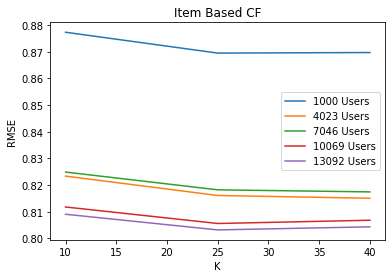

In [28]:
users = []
best_rmse_lst_item = []
best_mae_lst_item = []
fit_time_lst = []
test_time_lst = []
for usize in np.linspace(1000, user_size, 5):
    res, rmse, mae, y, x, fit_time, test_time = tuning_k(usize)
    users.append(usize)
    best_rmse_lst_item.append(rmse)
    best_mae_lst_item.append(mae)
    fit_time_lst.append(fit_time)
    test_time_lst.append(test_time)
    plt.plot(x, y, label = f'{usize} Users')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('Item Based CF')
plt.legend()
plt.show()    

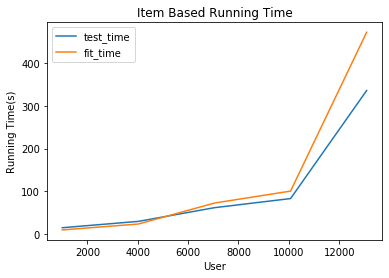

In [124]:
plt.plot(users, test_time, label = 'test_time')
plt.plot(users, fit_time, label = 'fit_time')
plt.xlabel('User')
plt.ylabel('Running Time(s)')
plt.title('Item Based Running Time')
plt.legend()
plt.show()  

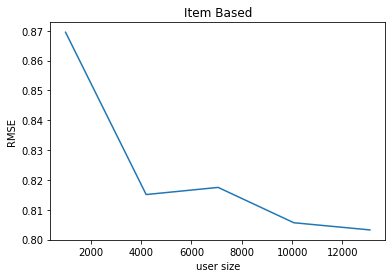

In [8]:
plt.plot(users, best_rmse_lst_item)
plt.xlabel('user size')
plt.ylabel('RMSE')
plt.title('Item Based')
plt.show()

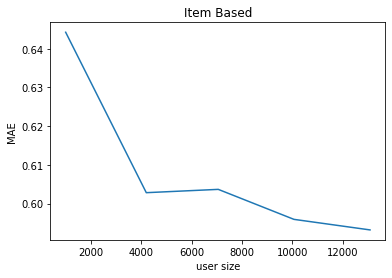

In [9]:
plt.plot(users, best_mae_lst_item)
plt.xlabel('user size')
plt.ylabel('MAE')
plt.title('Item Based')
plt.show()

## Model Based
-----

### Vanilla Matrix Factorization (without tuning)

In [16]:
df = spark.createDataFrame(sample)
(train_samp, test_samp) = df.randomSplit([0.8, 0.2])
model = ALS(userCol='userId', 
            itemCol='movieId', 
            ratingCol='rating').fit(train_samp)

In [17]:
predictions = model.transform(test_samp)
predictions.toPandas().head()

,userId,movieId,rating,timestamp,prediction
0,36445,148,4.5,2014-12-24 02:15:55,3.116213
1,3990,148,4.0,2015-02-02 03:04:54,2.649078
2,66277,471,3.0,2013-09-02 00:00:35,4.414796
3,21058,471,5.0,2014-05-15 12:01:12,3.795332
4,62003,471,4.0,2015-02-21 23:15:30,3.177825


In [18]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
result = evaluator.evaluate(predictions.na.drop())
print(f'default model RMSE = {result}')

default model RMSE = 0.7981597667997455


In [18]:
def multiALSrun(df, 
                k=3, 
                userCol='userId',
                itemCol='movieId',
                ratingCol='rating',
                metricName='rmse'):
    
    evaluations = np.array([])
    
    for i in range(0, k):
        (train, test) = df.randomSplit([(k-1.0)/k, 1.0/k])
        als = ALS(userCol=userCol, 
                  itemCol=itemCol, 
                  ratingCol=ratingCol)
        model = als.fit(train)
        pred = model.transform(test)
        evaluator = RegressionEvaluator(metricName=metricName, 
                                        labelCol='rating', 
                                        predictionCol='prediction')
        evaluation = evaluator.evaluate(pred.na.drop())
        print(f'k={i} rmse={evaluation}')
        evaluations = np.append(evaluations, evaluation)
    
    return np.mean(evaluations)

In [19]:
mean = multiALSrun(df, k=5)
print(f'average score for vanilla matrix factorization RMSE = {mean}')

k=0 rmse=0.8052490945282146
k=1 rmse=0.8017474336410721
k=2 rmse=0.8016818628680081
k=3 rmse=0.8024080992541102
k=4 rmse=0.8009875911819403
average score for vanilla matrix factorization RMSE = 0.8024148162946689


### Hyper-parameter Tuning
- try the investigate how RMSE would change with respect to increasing user sample size
- fix on the best latent factor, see how RMSE would change with respect to increasing regularization term
- fix on the best regularization term, see how RMSE would change with respect to increasing latent factor 

In [39]:
def cvModel(n_users=1000,
            ranks=[10, 20, 30],
            regs=[0.01, 0.05, 0.1, 0.5]):
    
    all_users = sample.userId.unique()
    nusers = np.random.choice(all_users, n_users, replace=False)
    nsample = sample.loc[sample.userId.isin(nusers)]
    df_n = spark.createDataFrame(nsample)
    (train_n, test_n) = df_n.randomSplit([80.0, 20.0])
    
    eval_rmse = RegressionEvaluator(metricName='rmse', 
                                    labelCol='rating', 
                                    predictionCol='prediction')
    eval_mae = RegressionEvaluator(metricName='mae', 
                                   labelCol='rating', 
                                   predictionCol='prediction')
    
    rmse_list = []
    mae_list = []
    
    for rank in ranks:
        for reg in regs:
            als = ALS(userCol='userId', 
                      itemCol='movieId', 
                      ratingCol='rating',
                      rank=rank,
                      regParam=reg)
            model = als.fit(train_n)
            pred = model.transform(test_n)
            rmse = eval_rmse.evaluate(pred.na.drop())
            mae = eval_mae.evaluate(pred.na.drop())
            # print(f'rank={rank}, regParam={reg}, rmse={evaluation}')
            rmse_list.append((rank, reg, rmse))
            mae_list.append((rank, reg, mae))
            
    best_rmse = sorted(rmse_list, key=lambda x: x[2])[0]
    best_mae = sorted(mae_list, key=lambda x: x[2])[0]
    
    results = {
        'rmse_list': rmse_list,
        'mae_list': mae_list,
        'best_rmse': best_rmse,
        'best_mae': best_mae,
    }
    
    return results

### Sample Size

In [22]:
all_evals = []
for usize in users:
    all_evals.append(cvModel(n_users=int(usize)))

In [23]:
best_rmse_lst = [evaluation['best_rmse'][2] for evaluation in all_evals]
best_mae_lst = [evaluation['best_mae'][2] for evaluation in all_evals]

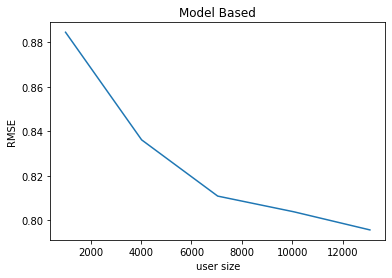

In [25]:
plt.plot(users, best_rmse_lst)
plt.xlabel('user size')
plt.ylabel('RMSE')
plt.title('Model Based')
plt.show()

### Fix Latent Factor, Change Regularization term

In [42]:
results_regs = cvModel(n_users=int(users[-1]), 
                       ranks=[30],
                       regs=[0.01, 0.02, 0.05, 0.1, 0.3, 0.5])

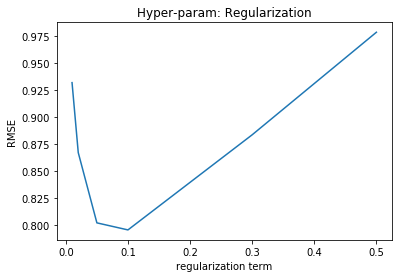

In [51]:
regs = np.array(results_regs['rmse_list'])[:,1]
rmse_regs = np.array(results_regs['rmse_list'])[:,2]

plt.plot(regs, rmse_regs)
plt.xlabel('regularization term')
plt.ylabel('RMSE')
plt.title('Hyper-param: Regularization')
plt.show()

### Fix Regularization term, Change Latent Factor

In [43]:
results_ranks = cvModel(n_users=int(users[-1]), 
                        ranks=[5, 10, 15, 20, 25, 30],
                        regs=[0.1])

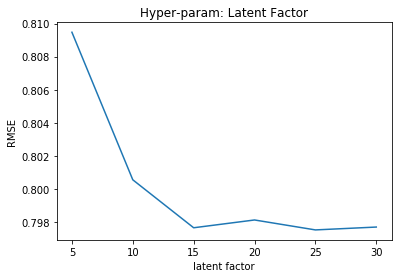

In [52]:
ranks = np.array(results_ranks['rmse_list'])[:,0]
rmse_ranks = np.array(results_ranks['rmse_list'])[:,2]

plt.plot(ranks, rmse_ranks)
plt.xlabel('latent factor')
plt.ylabel('RMSE')
plt.title('Hyper-param: Latent Factor')
plt.show()

# IV. Metrics Evaluation

---

## RMSE

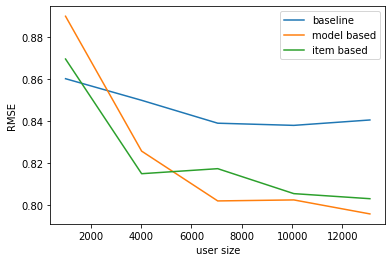

In [33]:
plt.plot(users, rmse_bsl, label='baseline')
plt.plot(users, best_rmse_lst, label='model based')
plt.plot(users, best_rmse_lst_item, label = 'item based')
plt.xlabel('user size')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

## MAE

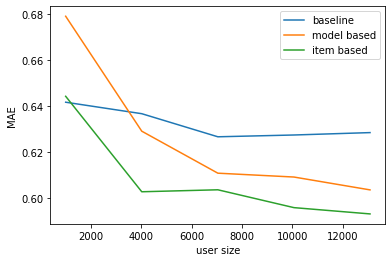

In [34]:
plt.plot(users, mae_bsl, label='baseline')
plt.plot(users, best_mae_lst, label='model based')
plt.plot(users, best_mae_lst_item, label='item based')
plt.xlabel('user size')
plt.ylabel('MAE')
plt.legend(loc='best')
plt.show()

In [27]:
KNN_test = pd.DataFrame(KNN_test)
KNN_test

,userId,movieId,actual,KNN_predictions
0,94009,2571,5.0,4.431479
1,126072,59306,0.5,3.260936
2,75199,5956,3.5,4.124878
3,19590,4896,4.5,3.524740
4,94148,71535,5.0,4.800215
5,69299,1517,1.0,2.367821
6,90850,77866,2.0,3.167533
7,84716,103372,3.5,3.627805
8,66756,58559,3.0,3.699456
9,96553,92152,3.5,3.767446


## Coverage

In [8]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

### 1.Baseline Model

In [32]:
trainset, testset = train_test_split(data, test_size=0.2)

baseline_algo.fit(trainset)
baseline_test = baseline_algo.test(testset)

baseline_test = pd.DataFrame(baseline_test)
baseline_test.drop("details", inplace=True, axis=1)
baseline_test.columns = ['userId', 'movieId', 'actual', 'baseline_predictions']

baseline_model = baseline_test.pivot_table(index='userId', columns='movieId', values='baseline_predictions').fillna(0)
baseline_test = baseline_test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})

recs_baseline = []
for user in baseline_test.index:
    baseline_predictions = get_users_predictions(user, 10, baseline_model)
    recs_baseline.append(baseline_predictions)

baseline_test['baseline_predictions'] = recs_baseline
catalog = sample.movieId.unique().tolist()

baseline_predictions = baseline_test.baseline_predictions.values.tolist()

baseline_coverage = recmetrics.coverage(baseline_predictions, catalog)


Estimating biases using sgd...


/Users/zhaotingting/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [33]:
baseline_coverage

26.06

### 2.KNN Baseline

In [35]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
KNN_algo = KNNBaseline(k=40, sim_options=sim_options)
KNN_algo.fit(trainset)
KNN_test = KNN_algo.test(testset) 

KNN_test = pd.DataFrame(KNN_test)
KNN_test.drop("details", inplace=True, axis=1)
KNN_test.columns = ['userId', 'movieId', 'actual', 'KNN_predictions']

KNN_model = KNN_test.pivot_table(index='userId', columns='movieId', values='KNN_predictions').fillna(0)
KNN_test = KNN_test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})

recs_KNN = []
for user in KNN_test.index:
    KNN_predictions = get_users_predictions(user, 10, KNN_model)
    recs_KNN.append(KNN_predictions)
    
KNN_test['KNN_predictions'] = recs_KNN

catalog = sample.movieId.unique().tolist()


KNN_predictions = KNN_test.KNN_predictions.values.tolist()
KNN_coverage = recmetrics.coverage(KNN_predictions, catalog)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


/Users/zhaotingting/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [36]:
KNN_coverage

28.29

### 3. Model Based

In [12]:
best_als = ALS(userCol='userId', 
               itemCol='movieId', 
               ratingCol='rating',
               rank=30,
               regParam=0.1)

df = spark.createDataFrame(sample)
(train_samp, test_samp) = df.randomSplit([0.8, 0.2])

best_estimator = best_als.fit(train_samp)

predictions = best_estimator.transform(test_samp)
df_mb = predictions.na.drop().toPandas()
df_mb.drop('timestamp', inplace=True, axis=1)
df_mb.columns = ['userId', 'movieId', 'actual', 'model_predictions']

model_based = df_mb.pivot_table(index='userId', columns='movieId', values='model_predictions').fillna(0)
df_mb = df_mb.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})

recs = []
for user in df_mb.index:
    mb_pred = get_users_predictions(user, 10, model_based)
    recs.append(mb_pred)
    
df_mb['model_predictions'] = recs

catalog = sample.movieId.unique().tolist()
model_predictions = df_mb.model_predictions.values.tolist()
model_coverage = recmetrics.coverage(model_predictions, catalog)

/Users/itachi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



In [13]:
model_coverage

28.03

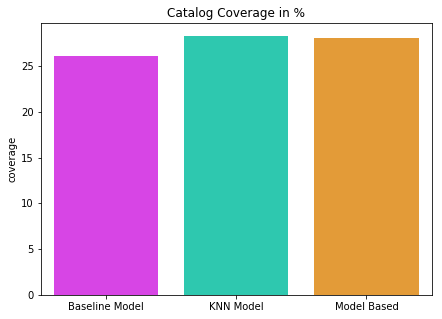

In [39]:
fig = plt.figure(figsize=(7, 5))

coverage_scores = [baseline_coverage, KNN_coverage, model_coverage]
model_names = ['Baseline Model', 'KNN Model', 'Model Based']

recmetrics.coverage_plot(coverage_scores, model_names)
plt.show()

# Recommendations
----

## Item-Based CF Recommendations

In [34]:
movies = pd.read_csv("./data/movies.csv")

In [20]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [50]:
top_n = get_top_n(KNN_test, n=10)

In [32]:
# To predict userID = 77641 Top 10 movies
def recommendation(userId):
    movieId = [top_n[userId][i][0] for i in range(10)]
    tmovie = []
    top = []
    for i, movieId in enumerate(movieId):
        top.append(f'Top {i+1}')
        tmovie.append(movies[movies['movieId'] == movieId]['title'].values)
    return pd.DataFrame(tmovie,top,columns=['Movie Title'])

In [121]:
recommendation(77641)

,Movie Title
Top 1,Spirited Away (Sen to Chihiro no kamikakushi) ...
Top 2,Before Sunset (2004)
Top 3,Amadeus (1984)
Top 4,12 Years a Slave (2013)
Top 5,Exit Through the Gift Shop (2010)
Top 6,Modern Times (1936)
Top 7,Citizen Kane (1941)
Top 8,Intouchables (2011)
Top 9,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Top 10,Taxi Driver (1976)


## Model Based CF Recommendation

In [23]:
def get_top_n_mb(predictions, n=10):
    """
    Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for userId, movieId, rating, _, prediction in predictions:
        top_n[userId].append((movieId, prediction))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [17]:
df_model = predictions.toPandas()

In [29]:
top_n_mb = get_top_n_mb(df_model.values, n=10)

In [37]:
def recommendation(userId):
    movieId = [top_n_mb[userId][i][0] for i in range(10)]
    tmovie = []
    top = []
    for i, movieId in enumerate(movieId):
        top.append(f'Top {i+1}')
        tmovie.append(movies[movies['movieId'] == movieId]['title'].values)
    return pd.DataFrame(tmovie,top,columns=['Movie Title'])

recommendation(77641)

,Movie Title
Top 1,Earthlings (2006)
Top 2,"Shawshank Redemption, The (1994)"
Top 3,Fight Club (1999)
Top 4,Whisper of the Heart (Mimi wo sumaseba) (1995)
Top 5,Modern Times (1936)
Top 6,Persepolis (2007)
Top 7,Amadeus (1984)
Top 8,Laputa: Castle in the Sky (Tenkû no shiro Rapy...
Top 9,Millennium Actress (Sennen joyû) (2001)
Top 10,"Prestige, The (2006)"
